In [92]:
using Pkg; Pkg.activate(".")
using PyPlot
using MUST
using DelimitedFiles

MUST.@import_dispatch "/shared-storage/eitner/model_grid/dispatch2";

  Activating environment at `/usr/local/autofs.shared/shared-storage/eitner/model_grid/MUST.jl/examples/initial_conditions/Project.toml`


# Target properties of the model

In [93]:
Teff = 5777.0
logg = log(2.75e4);

The corresponding model we want to compare it to

In [94]:
model = readdlm("../solar_model/av_stagger.dat", ',')
z_goal, T_goal, d_goal = model[:, 1], model[:, 2], model[:, 3];

The corresponding box dimensions based on the scale height

In [95]:
MUST.box_dimensions(Teff, exp(logg))

Dict{Symbol, Float64} with 2 entries:
  :z => 4.0299
  :x => 1.49682

EoS + Opacities

In [96]:
eos_path = "input_data/TSO_sun_Magg_v1.1"
eos      = MUST.SquareGasEOS(MUST.@in_dispatch(eos_path));

# 1. Investigate the Adiabat

In [97]:
function seed_location(T_ini, ρ_ini, z_goal, T_goal, d_goal)    
    ## Find the closest match between the model and the adiabat
    zT = argmin(abs.(T_goal .- T_ini))
    zR = argmin(abs.(d_goal .- ρ_ini))

    z_goal[zT], z_goal[zR]
end

seed_location (generic function with 1 method)

In [98]:
mean(x) = sum(x) / length(x)

mean (generic function with 1 method)

In [99]:
## Initial point of the simulation
T_ini = 12000.0
ρ_ini = 8e-7
z0    = last(seed_location(T_ini, ρ_ini, z_goal, T_goal, d_goal)) /1e8;
@info T_ini ρ_ini z0

#T_ini = 6750.0
#ρ_ini = 1e-7
#z0    = first(seed_location(T_ini, ρ_ini, z_goal, T_goal, d_goal)) /1e8;
#@info T_ini ρ_ini z0

┌ Info: 12000.0
│   ρ_ini = 8.0e-7
│   z0 = -0.6060736
└ @ Main /shared-storage/eitner/model_grid/MUST.jl/examples/initial_conditions/initial_conditions.ipynb:5


In [100]:
z,d,ee,t,p = MUST.initial_adiabat(eos, T_ini, ρ_ini, exp(logg), ee_min=1.9, nz=400, i0=120, z0_position=z0);

Temperature density diagram

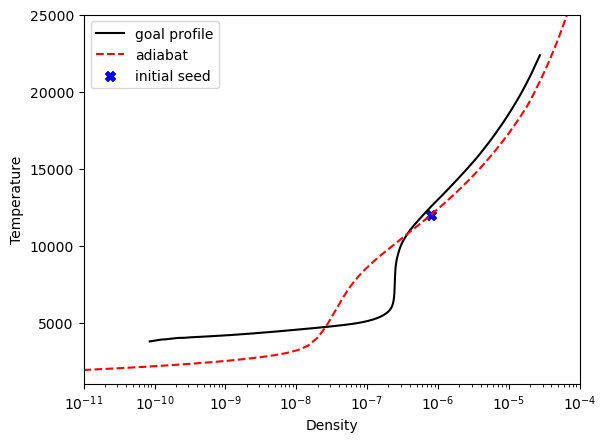

In [101]:
## Plotting
close()

# Curves
plt.plot(d_goal, T_goal, color="k",          label="goal profile")
plt.plot(d,      t,      color="r", ls="--", label="adiabat")

## initial point
plt.scatter([ρ_ini], [T_ini], color="b", marker="X", s=50, label="initial seed")

## Setup
plt.xlim(1e-11, 1e-4)
plt.ylim(1000, 25000)

## labels
plt.xlabel("Density")
plt.ylabel("Temperature")
plt.xscale("log")
plt.legend();

gcf()

Profiles against geometrical depth

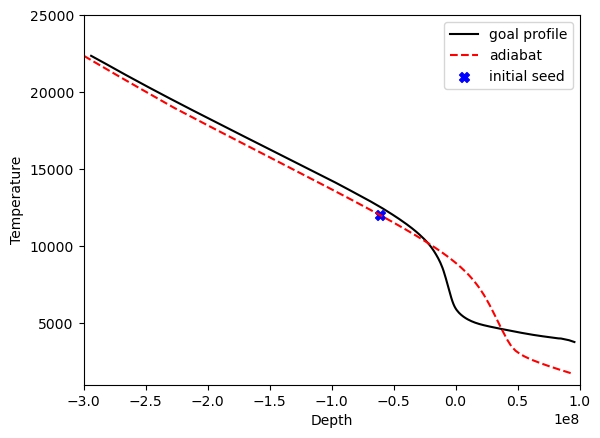

In [102]:
## Plotting
close()

# Curves
plt.plot(z_goal, T_goal, color="k",          label="goal profile")
plt.plot(z*1e8,      t,      color="r", ls="--", label="adiabat")

## initial point
plt.scatter([z0*1e8], [T_ini], color="b", marker="X", s=50, label="initial seed")

## Setup
plt.xlim(-3e8, 1e8)
plt.ylim(1000, 25000)

## labels
plt.xlabel("Depth")
plt.ylabel("Temperature")
plt.legend();

gcf()

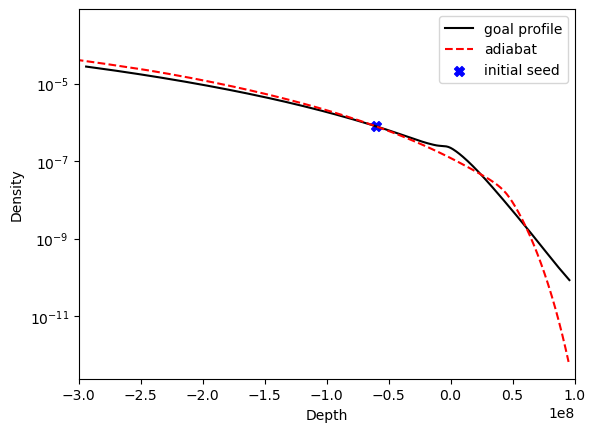

In [103]:
## Plotting
close()

# Curves
plt.plot(z_goal, d_goal, color="k",          label="goal profile")
plt.plot(z*1e8,      d,      color="r", ls="--", label="adiabat")

## initial point
plt.scatter([z0*1e8], [ρ_ini], color="b", marker="X", s=50, label="initial seed")

## Setup
plt.xlim(-3e8, 1e8)
#plt.ylim(1000, 25000)

## labels
plt.xlabel("Depth")
plt.ylabel("Density")
plt.yscale("log")
plt.legend();

gcf()

# General influence of the initial seed on the initial adiabat

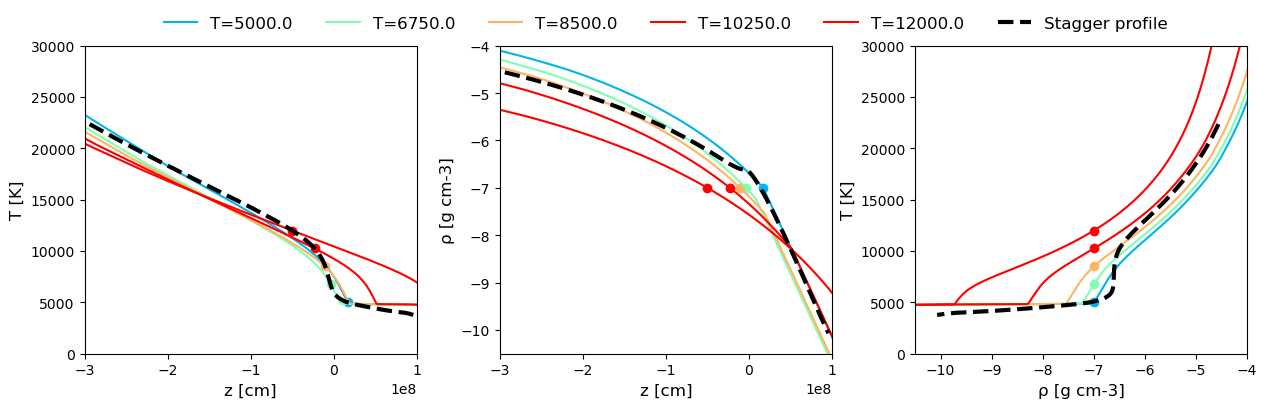

In [104]:
T_start = collect(range(5000.0, 12000.0, length=5))
ρ_start = 1e-7
z0      = [first(seed_location(T_start[i], ρ_start, z_goal, T_goal, d_goal)) /1e8 for i in eachindex(T_start)]
cmap =  plt.get_cmap("rainbow", 5)

close()
f, ax = plt.subplots(1, 3, figsize=(15,4))
plt.subplots_adjust(wspace=0.25)

for i in eachindex(T_start)
    z,d,ee,t,p = MUST.initial_adiabat(eos, T_start[i], ρ_start, exp(logg), ee_min=3.5, nz=400, i0=150, z0_position=z0[i])

    ax[1].plot(z*1e8, t, color=cmap(i/length(T_start)), label="T=$(T_start[i])")
    ax[2].plot(z*1e8, log10.(d), color=cmap(i/length(T_start)), label="T=$(T_start[i])")
    ax[3].plot(log10.(d), t, color=cmap(i/length(T_start)), label="T=$(T_start[i])")

    ax[1].scatter([z0[i]*1e8],         [T_start[i]], color=cmap(i/length(T_start)))
    ax[2].scatter([z0[i]*1e8],         [log10(ρ_start)], color=cmap(i/length(T_start)))
    ax[3].scatter([log10(ρ_start)], [T_start[i]], color=cmap(i/length(T_start)))
end

ax[1].plot(z_goal, T_goal, color="k", label="Stagger profile", lw=3, ls="--")
ax[2].plot(z_goal, log10.(d_goal), color="k", label="Stagger profile", lw=3, ls="--")
ax[3].plot(log10.(d_goal), T_goal, color="k", label="Stagger profile", lw=3, ls="--")

ax[1].set_xlim(-3e8, 1e8)
ax[2].set_xlim(-3e8, 1e8)
ax[3].set_xlim(-10.5, -4)

ax[1].set_ylim(0,30000)
ax[2].set_ylim(-10.5,-4)
ax[3].set_ylim(0,30000)

ax[1].set_xlabel("z [cm]", fontsize="large")
ax[2].set_xlabel("z [cm]", fontsize="large")
ax[3].set_xlabel("ρ [g cm-3]", fontsize="large")
ax[1].set_ylabel("T [K]", fontsize="large")
ax[2].set_ylabel("ρ [g cm-3]", fontsize="large")
ax[3].set_ylabel("T [K]", fontsize="large")

ax[2].legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=6, fontsize="large", framealpha=0);
gcf()

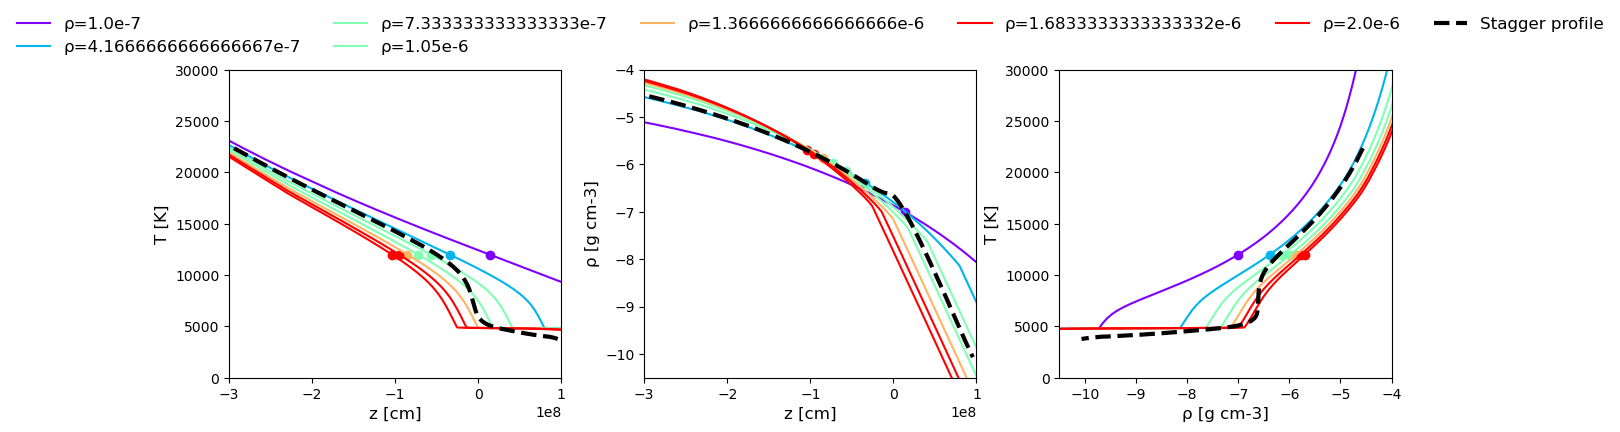

In [105]:
T_start = 12000.0
ρ_start = collect(range(1e-7, 2e-6, length=7))
z0      = zeros(length(ρ_start)) 
z0      = [last(seed_location(T_start, ρ_start[i], z_goal, T_goal, d_goal)) /1e8 for i in eachindex(ρ_start)]
cmap =  plt.get_cmap("rainbow", 5)


close()
f, ax = plt.subplots(1, 3, figsize=(15,4))
plt.subplots_adjust(wspace=0.25)


for i in eachindex(ρ_start)
    z,d,ee,t,p = MUST.initial_adiabat(eos, T_start, ρ_start[i], exp(logg), ee_min=3.5, nz=400, i0=120, z0_position=z0[i])

    ax[1].plot(z*1e8, t, color=cmap(i/length(ρ_start)), label="ρ=$(ρ_start[i])")
    ax[2].plot(z*1e8, log10.(d), color=cmap(i/length(ρ_start)), label="ρ=$(ρ_start[i])")
    ax[3].plot(log10.(d), t, color=cmap(i/length(ρ_start)), label="ρ=$(ρ_start[i])")

    ax[1].scatter([z0[i]*1e8],         [T_start], color=cmap(i/length(ρ_start)))
    ax[2].scatter([z0[i]*1e8],         [log10(ρ_start[i])], color=cmap(i/length(ρ_start)))
    ax[3].scatter([log10(ρ_start[i])], [T_start], color=cmap(i/length(ρ_start)))
end


ax[1].plot(z_goal, T_goal, color="k", label="Stagger profile", lw=3, ls="--")
ax[2].plot(z_goal, log10.(d_goal), color="k", label="Stagger profile", lw=3, ls="--")
ax[3].plot(log10.(d_goal), T_goal, color="k", label="Stagger profile", lw=3, ls="--")


ax[1].set_xlim(-3e8, 1e8)
ax[2].set_xlim(-3e8, 1e8)
ax[3].set_xlim(-10.5, -4)
ax[1].set_ylim(0,30000)
ax[2].set_ylim(-10.5,-4)
ax[3].set_ylim(0,30000)


ax[1].set_xlabel("z [cm]", fontsize="large")
ax[2].set_xlabel("z [cm]", fontsize="large")
ax[3].set_xlabel("ρ [g cm-3]", fontsize="large")
ax[1].set_ylabel("T [K]", fontsize="large")
ax[2].set_ylabel("ρ [g cm-3]", fontsize="large")
ax[3].set_ylabel("T [K]", fontsize="large")

ax[2].legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=6, fontsize="large", framealpha=0)
gcf()